
## Установка pyexasol и подключение к БД

In [1]:
!pip install pyexasol 

     |████████████████████████████████| 51kB 2.5MB/s 
     |████████████████████████████████| 61kB 3.3MB/s 


In [2]:
pwd = 'lhRXL7Krc'
usr ='PUB3477'

schema= 'PUB3477'

In [3]:
import pandas as pd
import numpy as np

import requests

import pyexasol

import matplotlib.pyplot as plt
import matplotlib.style as style

import seaborn as sns
%matplotlib inline

style.use('fivethirtyeight')


C = pyexasol.connect(dsn='demodb.exasol.com:8563', user=usr, password=pwd, schema= schema)

In [4]:
sql = """
SELECT CURRENT_DATE()
"""
res = C.export_to_pandas(sql)

res.head()

,CURRENT_DATE
0,2021-04-12


## Загружаем данные

в IDE скрипт aha_2021.sql

## EDA в Exasol

In [6]:
sql = """
SELECT COUNT(*) FROM online_retail_stg
"""
df = C.export_to_pandas(sql)

df.head()


,COUNT(*)
0,541909


In [7]:
sql = """
SELECT * FROM online_retail_stg LIMIT 1000
"""
df = C.export_to_pandas(sql)

df.head()

,INVOICENO,STOCKCODE,DESCRIPTION,QUANTITY,INVOICEDATE,UNITPRICE,CUSTOMERID,COUNTRY
0,\n537086,22750,FELTCRAFT PRINCESS LOLA DOLL,16,05.12.2010 12:01:00,3.75,15332.0,Lithuania
1,\n537086,22751,FELTCRAFT PRINCESS OLIVIA DOLL,12,05.12.2010 12:01:00,3.75,15332.0,Lithuania
2,\n537086,21429,RED GINGHAM ROSE JEWELLERY BOX,16,05.12.2010 12:01:00,1.65,15332.0,Lithuania
3,\n537086,85206A,CREAM FELT EASTER EGG BASKET,24,05.12.2010 12:01:00,1.65,15332.0,Lithuania
4,\n537086,22021,BLUE FELT EASTER EGG BASKET,24,05.12.2010 12:01:00,1.65,15332.0,Lithuania


In [8]:
df.describe()

,QUANTITY,UNITPRICE,CUSTOMERID
count,1000.000000,1000.000000,923.000000
mean,11.630000,3.063210,15585.468039
std,32.988018,2.925404,2023.392869
min,-20.000000,0.000000,12586.000000
25%,1.000000,1.250000,13468.000000
50%,3.000000,2.100000,15987.000000
75%,12.000000,3.750000,17690.000000
max,480.000000,29.950000,18229.000000


### То же самое но в SQL

In [9]:
table_name = 'online_retail_stg'

sql = ""

skipp_cols = ['INVOICENO']

for col in df.columns:

  if col in skipp_cols:
    continue


  if df[col].dtype in [np.int, np.int32, np.int64, np.float, np.float16, np.float32, np.float64, np.float128] :
    AVG = f'AVG({col}) AS avg_value'
  else:
    AVG = 'NULL AS avg_value'

  sql_tmpl = f"""
          SELECT
            '{col}' AS col_name
            , COUNT(*) AS cnt
            , COUNT(DISTINCT {col}) AS cnt_distinct 
            , SUM(IF {col} IS NULL THEN 1 ELSE 0 ENDIF) AS is_null_cnt
            , CAST(MIN({col})AS VARCHAR(100)) AS min_value
            , {AVG} 
            , CAST(MAX({col})AS VARCHAR(100)) AS max_value     
          FROM
             {table_name}
     """
  
  if sql == "":
    sql = sql_tmpl
  else:
    sql = sql + """
    
    UNION ALL
    
    """ + sql_tmpl
    
print(sql)



df = C.export_to_pandas(sql)

df.head(20)


          SELECT
            'STOCKCODE' AS col_name
            , COUNT(*) AS cnt
            , COUNT(DISTINCT STOCKCODE) AS cnt_distinct 
            , SUM(IF STOCKCODE IS NULL THEN 1 ELSE 0 ENDIF) AS is_null_cnt
            , CAST(MIN(STOCKCODE)AS VARCHAR(100)) AS min_value
            , NULL AS avg_value 
            , CAST(MAX(STOCKCODE)AS VARCHAR(100)) AS max_value     
          FROM
             online_retail_stg
     
    
    UNION ALL
    
    
          SELECT
            'DESCRIPTION' AS col_name
            , COUNT(*) AS cnt
            , COUNT(DISTINCT DESCRIPTION) AS cnt_distinct 
            , SUM(IF DESCRIPTION IS NULL THEN 1 ELSE 0 ENDIF) AS is_null_cnt
            , CAST(MIN(DESCRIPTION)AS VARCHAR(100)) AS min_value
            , NULL AS avg_value 
            , CAST(MAX(DESCRIPTION)AS VARCHAR(100)) AS max_value     
          FROM
             online_retail_stg
     
    
    UNION ALL
    
    
          SELECT
            'QUANTITY' AS col_name
            , COU

,COL_NAME,CNT,CNT_DISTINCT,IS_NULL_CNT,MIN_VALUE,AVG_VALUE,MAX_VALUE
0,STOCKCODE,541909,4070,0,10002,NaN,m
1,DESCRIPTION,541909,4211,1454,*Boombox Ipod Classic,NaN,wrongly sold sets
2,QUANTITY,541909,722,0,-80995,9.552250,80995
3,INVOICEDATE,541909,23260,0,01.02.2011 10:00:00,NaN,31.10.2011 9:58:00
4,UNITPRICE,541909,1629,0,-11062.06,4.611114,38970
5,CUSTOMERID,541909,4372,135080,12346,15287.690570,18287
6,COUNTRY,541909,38,0,Australia,NaN,Unspecified


## Перцентильный анализ

In [10]:
# вью с предрасчетом
sql = """
CREATE OR REPLACE VIEW online_retail_percentile_base AS  
SELECT
  TO_DATE(DATE_TRUNC('quarter', TO_TIMESTAMP(InvoiceDate, 'DD.MM.YYYY HH:MI:SS'))) AS quarter
  , CustomerID as dim
  , SUM(Quantity*UnitPrice) AS amount
  , COUNT(DISTINCT InvoiceNo) AS sales_cnt
FROM
  online_retail_stg
WHERE 
  CustomerID IS NOT NULL
GROUP BY 
  1
  , 2
;
"""

stmt = C.execute(sql)

In [11]:
sql = """
SELECT quarter, count(*) FROM online_retail_percentile_base GROUP BY 1
"""
df = C.export_to_pandas(sql)

df.head()

,QUARTER,COUNT(*)
0,2011-01-01,1812
1,2011-04-01,2024
2,2011-07-01,2196
3,2011-10-01,2601
4,2010-10-01,948


In [12]:
q1 = '2011-04-01'

q2 = '2011-07-01'

sql = f"""
WITH ranked_q1 AS (
SELECT 
  dim
  , amount AS amount_q1
  , RANK() OVER ( ORDER BY amount DESC) AS rnk_q1
  , COUNT(DISTINCT dim) OVER() AS cnt_q1
  , sales_cnt AS sales_cnt_q1
FROM 
  online_retail_percentile_base 
WHERE 
  quarter = DATE '{q1}'

)
, ranked_q2 AS (
SELECT
   dim
  , amount AS amount_q2
  , RANK() OVER ( ORDER BY amount DESC) AS rnk_q2
  , COUNT(DISTINCT dim) OVER() AS cnt_q2
  , sales_cnt AS sales_cnt_q2
FROM 
  online_retail_percentile_base 
WHERE 
  quarter = DATE '{q2}'

)
SELECT 
  COALESCE(ranked_q2.dim, ranked_q1.dim) AS dim
  , COALESCE(amount_q2, 0) AS amount_q2
  , COALESCE(amount_q1, 0) AS amout_q1
  , COALESCE(sales_cnt_q2,0) AS sales_cnt_q2
  , COALESCE(sales_cnt_q1,0) AS sales_cnt_q1
  , COALESCE(1- rnk_q2/cnt_q2, 0) AS prcentile_q2
  , COALESCE(1- rnk_q1/cnt_q1, 0) AS prcentile_q1
  , IF COALESCE(amount_q2, 0) > COALESCE(amount_q1, 0) THEN 'Growth' ELSE 'Fall' ENDIF AS color
FROM
  ranked_q2
FULL JOIN
  ranked_q1
ON 
  ranked_q2.dim = ranked_q1.dim

;

"""
df = C.export_to_pandas(sql)

df.head()

,DIM,AMOUNT_Q2,AMOUT_Q1,SALES_CNT_Q2,SALES_CNT_Q1,PRCENTILE_Q2,PRCENTILE_Q1,COLOR
0,17091,697.59,1106.26,2,3,0.677140,0.844862,Fall
1,13055,869.55,344.86,2,1,0.747723,0.442688,Growth
2,17975,1174.88,818.13,4,3,0.834699,0.762352,Growth
3,14407,1138.10,615.80,5,3,0.827869,0.676383,Growth
4,13969,1361.17,1741.80,3,5,0.869308,0.919466,Fall


### Визуализируем результат

Text(0.5, 1, 'ABC segments ')

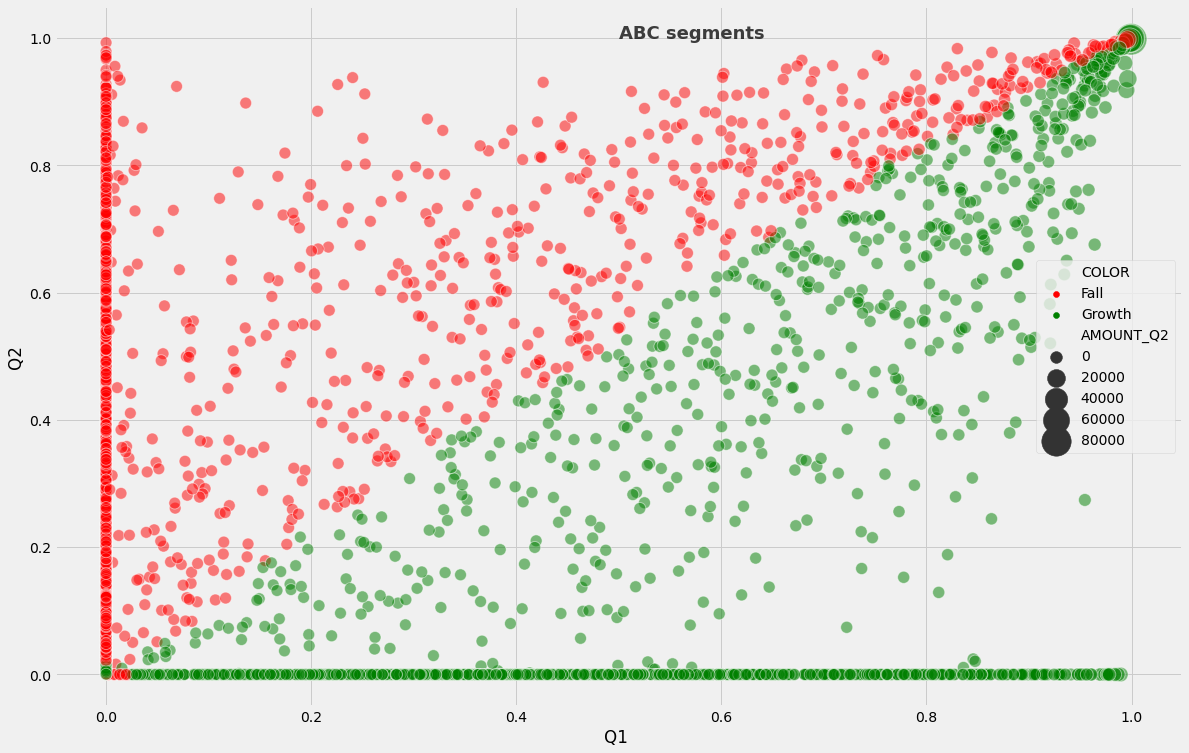

In [13]:
color_dict = {'Growth':'green',
              'Fall':'red',
}

g = sns.scatterplot(x="PRCENTILE_Q2", y="PRCENTILE_Q1",
              hue="COLOR",
              palette=color_dict, 
              alpha = 0.5,
              legend='brief',
              size= 'AMOUNT_Q2',
              sizes=(100, 1000),
              data=df)
              
              
plt.xlabel("Q1 ")
plt.ylabel("Q2")
plt.legend(loc = 'best')


F = plt.gcf()
Size = F.get_size_inches()
F.set_size_inches(Size[0]*3, Size[1]*3, forward=True) 

plt.text(x = 0.5, y = 1, s = "ABC segments ",
               fontsize = 18, weight = 'bold', alpha = .75)

## RFM сегментация

In [14]:
# предварительный расчет
sql = """
CREATE OR REPLACE VIEW online_retail_orders AS
SELECT
  InvoiceNo AS order_id
  , TO_TIMESTAMP(InvoiceDate, 'DD.MM.YYYY HH:MI:SS') AS order_date
  , CustomerID AS customer_id
  , SUM(Quantity*UnitPrice) AS amount
  , MAX(TO_TIMESTAMP(InvoiceDate, 'DD.MM.YYYY HH:MI:SS')) OVER() + INTERVAL '1' DAY AS today
FROM 
  online_retail_stg
WHERE 
  CustomerID IS NOT NULL
GROUP BY 
  1
  , 2
  , 3
HAVING 
  SUM(Quantity*UnitPrice) >0
;
"""
stmt = C.execute(sql)

In [15]:
sql = """
CREATE OR REPLACE VIEW online_retail_RFM AS
WITH base AS (
SELECT 
  customer_id
  , MIN(DAYS_BETWEEN(today, order_date)) AS Recency
  , COUNT(DISTINCT order_id) AS Frequency
  , SUM(amount) AS Monetary
FROM
  online_retail_orders AS orders
GROUP BY 
  1
)
, bins AS(
SELECT
     MIN(Recency) As R_MIN
     , PERCENTILE_CONT(0.2) WITHIN GROUP (ORDER BY Recency) AS R_20
     , PERCENTILE_CONT(0.4) WITHIN GROUP (ORDER BY Recency) AS R_40
     , PERCENTILE_CONT(0.6) WITHIN GROUP (ORDER BY Recency) AS R_60
     , PERCENTILE_CONT(0.8) WITHIN GROUP (ORDER BY Recency) AS R_80
     , MAX(Recency) As R_MAX
     
     , MIN(Frequency) As F_MIN
     , PERCENTILE_CONT(0.2) WITHIN GROUP (ORDER BY Frequency) AS F_20
     , PERCENTILE_CONT(0.4) WITHIN GROUP (ORDER BY Frequency) AS F_40
     , PERCENTILE_CONT(0.6) WITHIN GROUP (ORDER BY Frequency) AS F_60
     , PERCENTILE_CONT(0.8) WITHIN GROUP (ORDER BY Frequency) AS F_80
     , MAX(Frequency) As F_MAX


     , MIN(Monetary) As M_MIN
     , PERCENTILE_CONT(0.2) WITHIN GROUP (ORDER BY Monetary) AS M_20
     , PERCENTILE_CONT(0.4) WITHIN GROUP (ORDER BY Monetary) AS M_40
     , PERCENTILE_CONT(0.6) WITHIN GROUP (ORDER BY Monetary) AS M_60
     , PERCENTILE_CONT(0.8) WITHIN GROUP (ORDER BY Monetary) AS M_80
     , MAX(Monetary) As M_MAX
FROM 
    base
)
, rfm AS(
SELECT
 customer_id
  , Recency
  , Frequency
  , Monetary
  , CASE 
         WHEN Recency <= R_20 THEN 5
         WHEN Recency <= R_40 THEN 4
         WHEN Recency <= R_60 THEN 3
         WHEN Recency <= R_80 THEN 2
         ELSE 1
    END AS R
 , CASE 
         WHEN Frequency <= F_20 THEN 1
         WHEN Frequency <= F_40 THEN 2
         WHEN Frequency <= F_60 THEN 3
         WHEN Frequency <= F_80 THEN 4
         ELSE 5
    END AS F
   , CASE 
         WHEN Monetary <= M_20 THEN 1
         WHEN Monetary <= M_40 THEN 2
         WHEN Monetary <= M_60 THEN 3
         WHEN Monetary <= M_80 THEN 4
         ELSE 5
    END AS M 
    , R_MIN
    , R_MAX
    , F_MIN
    , F_MAX
    , M_MIN
    , M_MAX
FROM
  base
CROSS JOIN 
  bins
)
, seg_map AS (

  SELECT '[1-2][1-2]' AS segKey, 'hibernating' AS segValue
UNION ALL
  SELECT '[1-2][3-4]' , 'at risk'  
UNION ALL
  SELECT '[1-2]5', 'can not loose'  
UNION ALL
  SELECT '3[1-2]', 'about to sleep'
UNION ALL
  SELECT '33', 'need attention'
UNION ALL
  SELECT '[3-4][4-5]', 'loyal customers'
UNION ALL
  SELECT '41', 'promising'
UNION ALL
  SELECT '51', 'new customers'
UNION ALL
  SELECT '[4-5][2-3]', 'potential loyalists'
UNION ALL
  SELECT '5[4-5]', 'champions'
 )
SELECT
    rfm.*
   , R||F||M AS RFM_Score
   , segValue  AS Segment
FROM 
  rfm
CROSS JOIN
  seg_map
WHERE 
   R||F REGEXP_LIKE segKey
ORDER BY 
  customer_id
   
;  

"""
stmt = C.execute(sql)

In [16]:
sql = """
SELECT 
  * 
FROM 
  online_retail_RFM
"""
df = C.export_to_pandas(sql)

df.head()

,CUSTOMER_ID,RECENCY,FREQUENCY,MONETARY,R,F,M,R_MIN,R_MAX,F_MIN,F_MAX,M_MIN,M_MAX,RFM_SCORE,SEGMENT
0,12346,326,1,77183.60,1,1,5,1,374,1,209,3.75,280206.02,115,hibernating
1,12347,3,7,4310.00,5,5,5,1,374,1,209,3.75,280206.02,555,champions
2,12348,76,4,1797.24,2,4,4,1,374,1,209,3.75,280206.02,244,at risk
3,12349,19,1,1757.55,4,1,4,1,374,1,209,3.75,280206.02,414,promising
4,12350,311,1,334.40,1,1,2,1,374,1,209,3.75,280206.02,112,hibernating


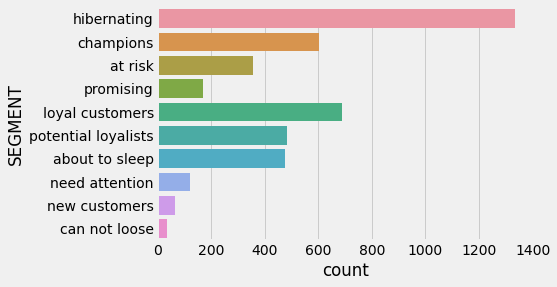

In [17]:
sns.countplot(y='SEGMENT',data=df)

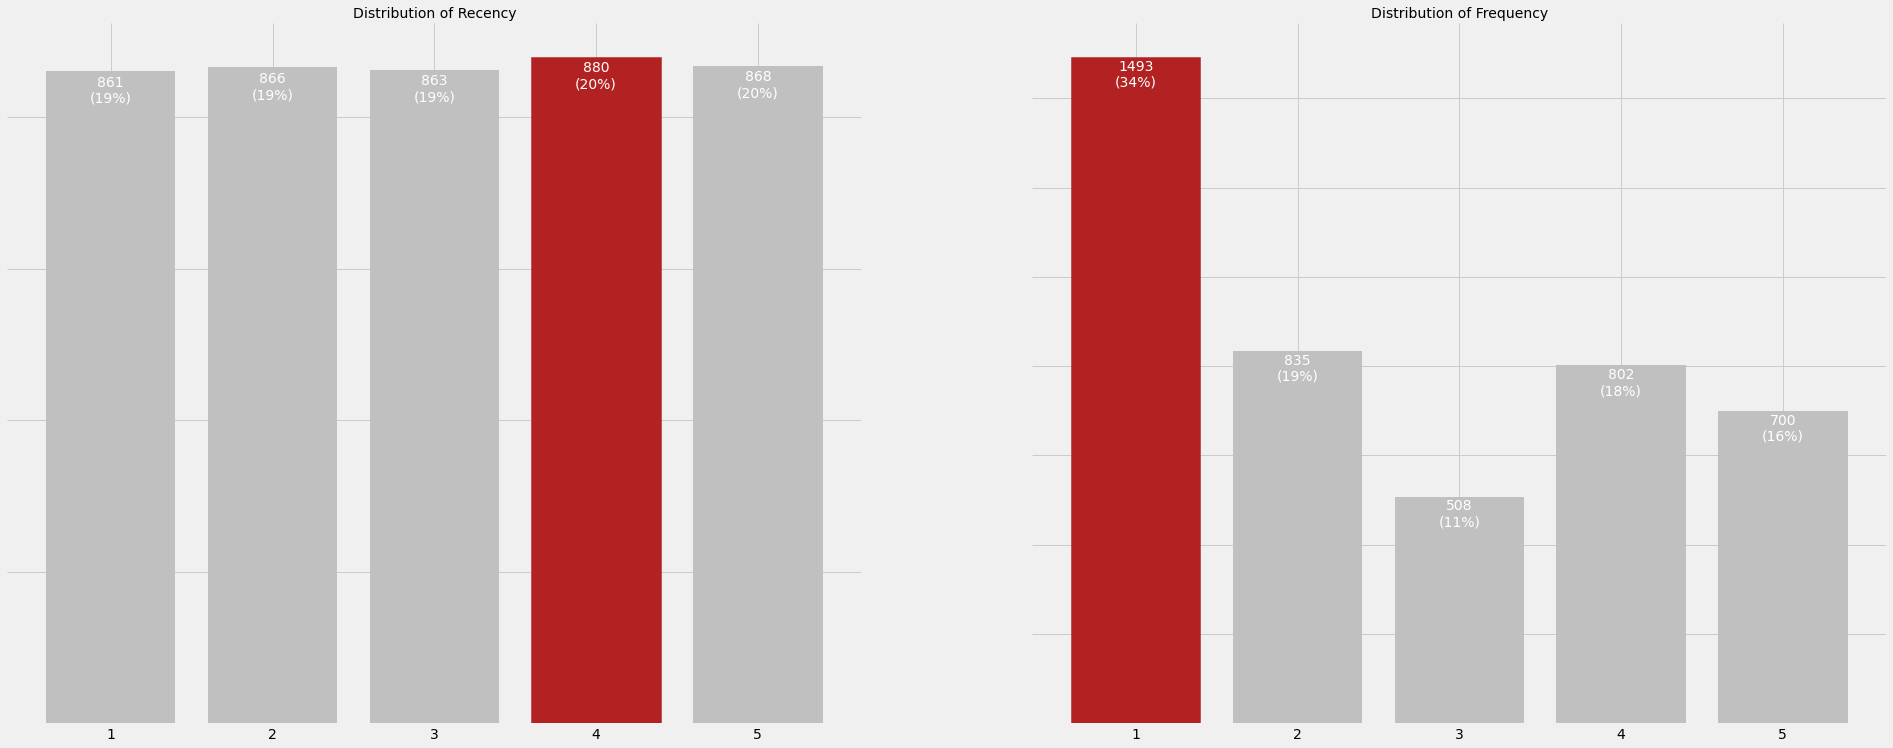

In [18]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

for i, p in enumerate(['R', 'F']):
    parameters = {'R':'Recency', 'F':'Frequency'}
    y = df[p].value_counts().sort_index()
    x = y.index
    ax = axes[i]
    bars = ax.bar(x, y, color='silver')
    ax.set_frame_on(False)
    ax.tick_params(left=False, labelleft=False, bottom=False)
    ax.set_title('Distribution of {}'.format(parameters[p]),
                fontsize=14)
    for bar in bars:
        value = bar.get_height()
        if value == y.max():
            bar.set_color('firebrick')
        ax.text(bar.get_x() + bar.get_width() / 2,
                value - 5,
                '{}\n({}%)'.format(int(value), int(value * 100 / y.sum())),
               ha='center',
               va='top',
               color='w')
        

F = plt.gcf()
Size = F.get_size_inches()
F.set_size_inches(Size[0]*3, Size[1]*3, forward=True) 
plt.show()

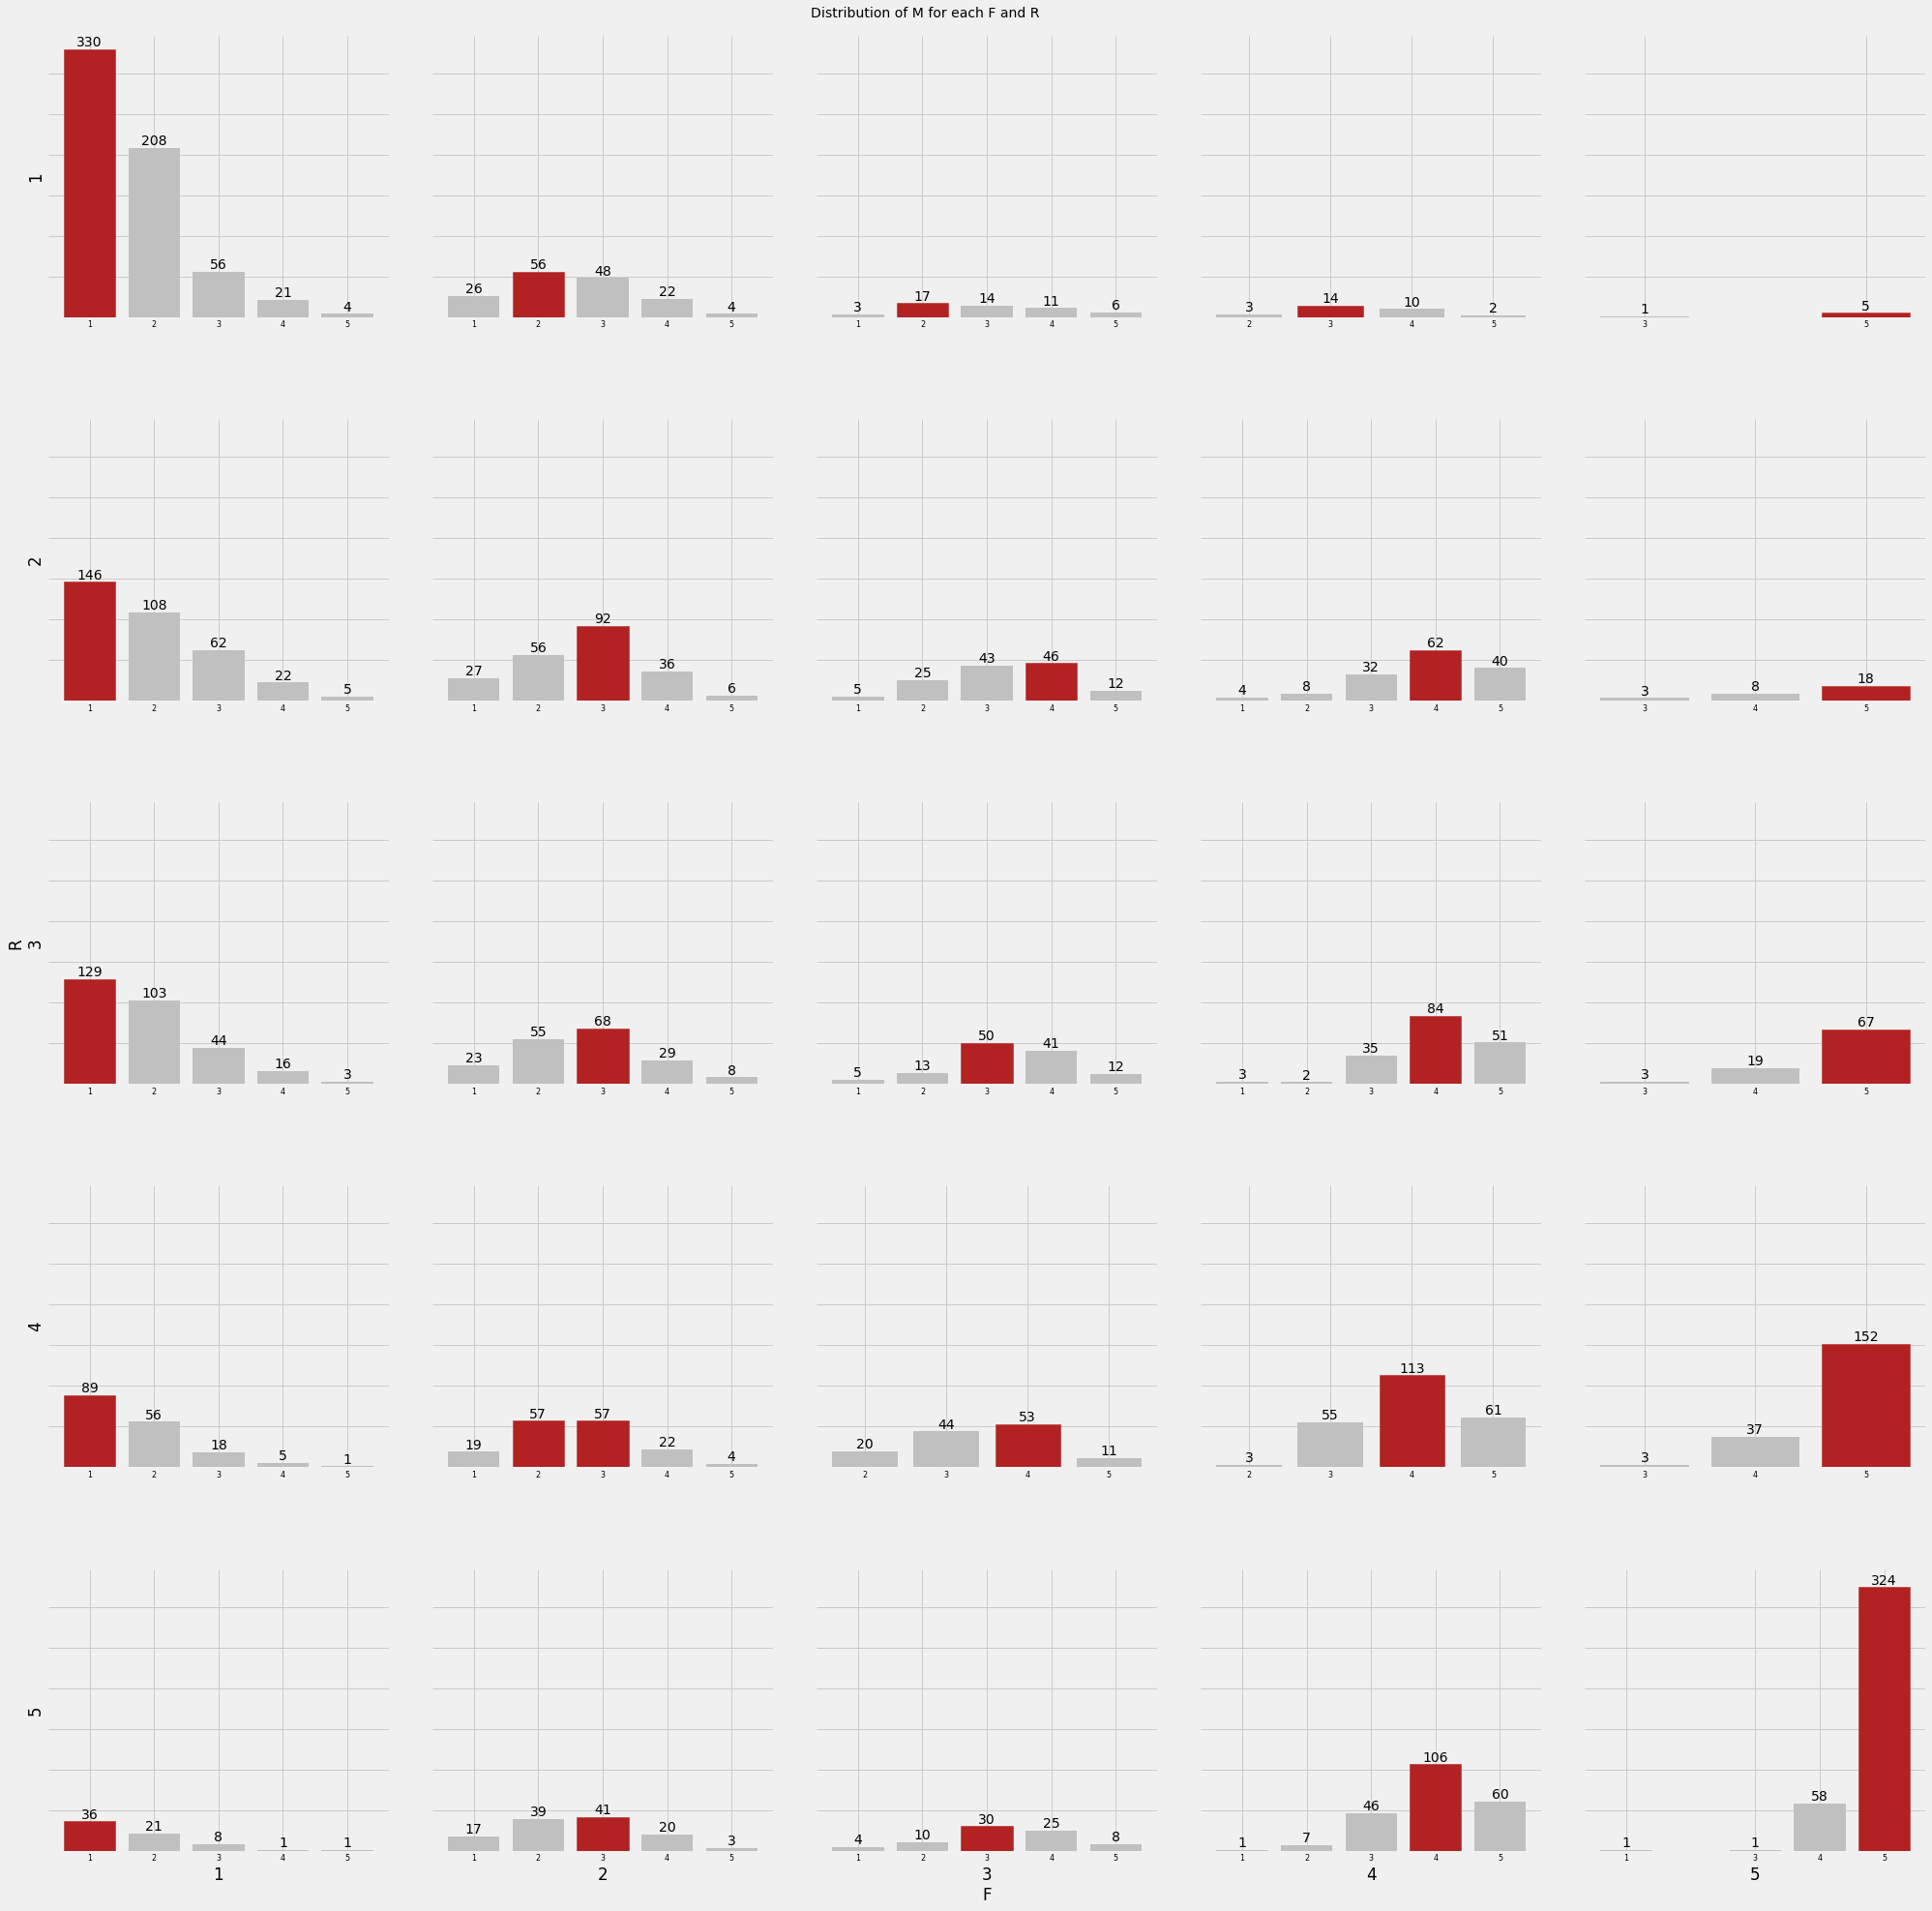

In [19]:

fig, axes = plt.subplots(nrows=5, ncols=5,
                         sharex=False, sharey=True,
                         figsize=(10, 10))

r_range = range(1, 6)
f_range = range(1, 6)
for r in r_range:
    for f in f_range:
        y = df[(df['R'] == r) & (df['F'] == f)]['M'].value_counts().sort_index()
        x = y.index
        ax = axes[r - 1, f - 1]
        bars = ax.bar(x, y, color='silver')
        if r == 5:
            if f == 3:
                ax.set_xlabel('{}\nF'.format(f), va='top')
            else:
                ax.set_xlabel('{}\n'.format(f), va='top')
        if f == 1:
            if r == 3:
                ax.set_ylabel('R\n{}'.format(r))
            else:
                ax.set_ylabel(r)
        ax.set_frame_on(False)
        ax.tick_params(left=False, labelleft=False, bottom=False)
        ax.set_xticks(x)
        ax.set_xticklabels(x, fontsize=8)

        for bar in bars:
            value = bar.get_height()
            if value == y.max():
                bar.set_color('firebrick')
            ax.text(bar.get_x() + bar.get_width() / 2,
                    value,
                    int(value),
                    ha='center',
                    va='bottom',
                    color='k')
fig.suptitle('Distribution of M for each F and R',
             fontsize=14)
plt.tight_layout()

F = plt.gcf()
Size = F.get_size_inches()
F.set_size_inches(Size[0]*3, Size[1]*3, forward=True)
plt.show()


In [20]:
sql = """
SELECT 
  R
  , F
  , Segment
  , COUNT(*) AS cnt
FROM 
  online_retail_RFM
GROUP BY 
  R, F, Segment
"""
df = C.export_to_pandas(sql)


Text(0.5, 5.5, 'RFM segments ')

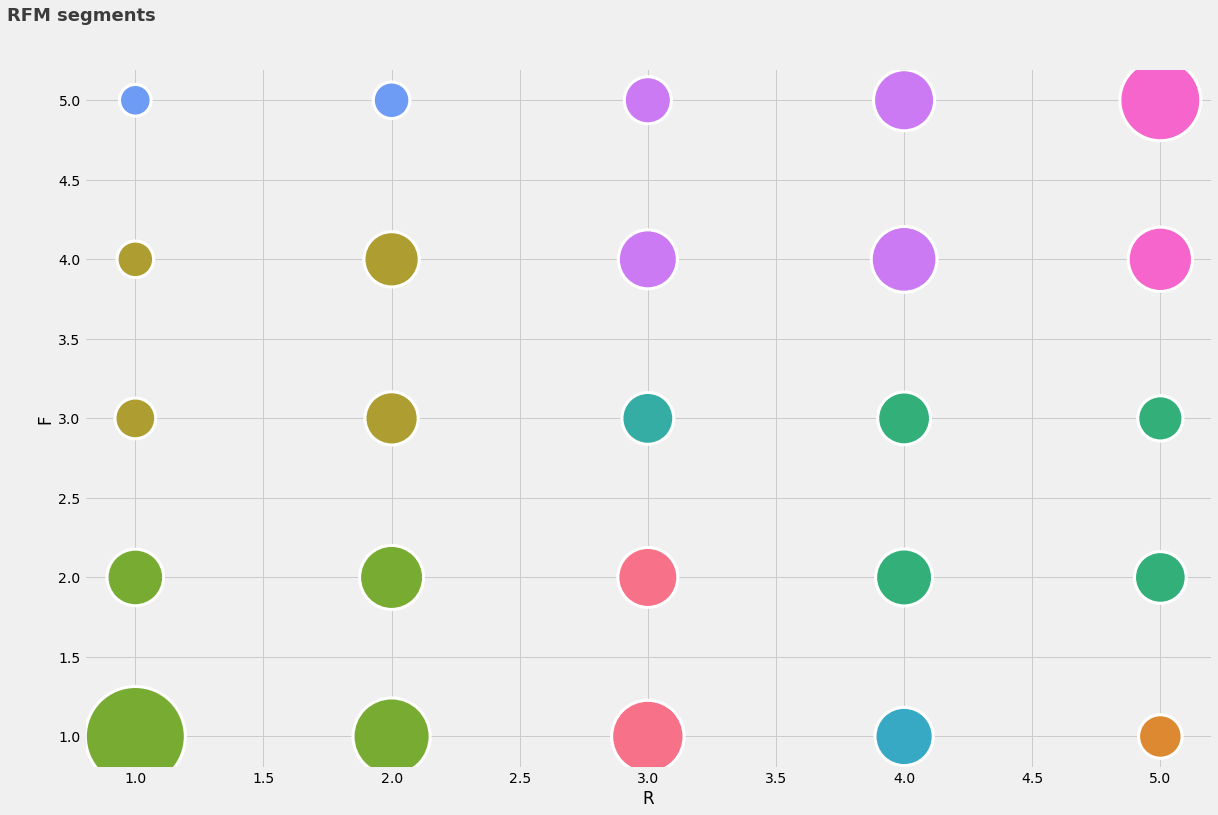

In [21]:
color_dict = {'Growth':'green',
              'Fall':'red',
}

g = sns.scatterplot(x="R", y="F",
             hue="SEGMENT",
             # palette=color_dict, 
              legend=False,
              size= 'CNT',
              sizes=(1000, 10000),
              data=df)
              
              
plt.xlabel("R")
plt.ylabel("F")

F = plt.gcf()
Size = F.get_size_inches()
F.set_size_inches(Size[0]*3, Size[1]*3, forward=True) 

plt.text(x = 0.5, y = 5.5, s = "RFM segments ",
               fontsize = 18, weight = 'bold', alpha = .75)

## Статистические тесты

In [22]:
# функция расчета p-value
sql = """
CREATE OR REPLACE PYTHON3 SCALAR SCRIPT ttest_ind_from_stats(mean1 DOUBLE, std1 DOUBLE, nobs1 DECIMAL, mean2 DOUBLE, std2 DOUBLE, nobs2 DECIMAL, equal_var BOOLEAN)
EMITS (statistic DOUBLE, pvalue DOUBLE) AS
 
from scipy.stats import ttest_ind_from_stats
 
def run(ctx):
 
 
  t=ttest_ind_from_stats(mean1=ctx.mean1, std1=ctx.std1, nobs1=ctx.nobs1,
                     mean2=ctx.mean2, std2=ctx.std2, nobs2=ctx.nobs2, equal_var = ctx.equal_var)
 
  ctx.emit(t[0].item(), t[1].item())
/ 
"""
stmt = C.execute(sql)

In [23]:
sql = f"""
CREATE OR REPLACE VIEW base_stats_by_order AS  
WITH agg AS (
SELECT
  Country
  , InvoiceNo
  , SUM(Quantity*UnitPrice) AS amount
 FROM 
  online_retail_stg
WHERE 
  CustomerID IS NOT NULL
  --AND Country IN ('Germany','France')
GROUP BY 
  1,2
HAVING 
  SUM(Quantity*UnitPrice) >0
)
SELECT
  Country
  , AVG(AMOUNT) AS mean
  , STDDEV_SAMP(AMOUNT) AS std
  , VAR_SAMP(AMOUNT) AS s
  , COUNT(*) AS nobs
FROM
  agg
GROUP BY
   1
"""
stmt = C.execute(sql)

In [24]:
sql = """

SELECT 
  *
FROM 
  base_stats_by_order
WHERE Country IN ('Germany','France')

"""
df = C.export_to_pandas(sql)

df.head()

,COUNTRY,MEAN,STD,S,NOBS
0,France,537.336889,687.253543,472317.432186,389
1,Germany,500.803370,608.916234,370778.979831,457


In [25]:
sql = """
WITH c1 AS ( 
SELECT 
  Country
  , mean AS mean
  , std AS std
  , nobs AS nobs
  , s/nobs AS s
 
FROM 
  base_stats_by_order
ORDER BY
  1
)
 
SELECT 
  c1.Country AS country1
  , c1.mean AS mean1
  , c1.std AS std1
  , c1.nobs AS nobs1
  , c2.Country AS country2
  , c2.mean AS mean2
  , c2.std AS std2
  , c2.nobs AS nobs2
  , CONCAT( c1.Country, '_vs_' , c2.Country) as test
  , SQRT(c1.s+c2.s) AS se
  , c1.mean - c2.mean AS diff_mean
  , (c1.mean - c2.mean)/CAST(GREATEST(c2.mean, c2.mean) AS DOUBLE) AS uplift
  , 4*SQRT(c1.s+c2.s)/CAST(SQRT(c1.nobs + c2.nobs - 2)  AS DOUBLE) AS mde
  , (c1.mean - c2.mean) / CAST(SQRT(c1.s+c2.s) AS double) AS t_statistic
  , ttest_ind_from_stats(c1.mean, c1.std, c1.nobs, c2.mean, c2.std, c2.nobs, FALSE) 
FROM
 c1
JOIN 
 c1 As c2 
ON 
  c1.Country != c2.Country AND c1.Country = 'Germany' AND c2.Country ='France'
"""
df = C.export_to_pandas(sql)

df.head()


,COUNTRY1,MEAN1,STD1,NOBS1,COUNTRY2,MEAN2,STD2,NOBS2,TEST,SE,DIFF_MEAN,UPLIFT,MDE,T_STATISTIC,STATISTIC,PVALUE
0,Germany,500.80337,608.916234,457,France,537.336889,687.253543,389,Germany_vs_France,45.005735,-36.53352,-0.06799,6.196645,-0.811753,-0.811753,0.417181


Результат можно сравнить с онлайн калькулятором [www.evanmiller.org](https://www.evanmiller.org/ab-testing/t-test.html#!537.336889/687.253543/389;500.80337/608.916234/457@95)